In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import CubicSpline
from skimage.io import imread

In [2]:
#import the pH calibration file with 1 curve (or merged data with n-numder 

data= r"../data/master_table.csv"
df= pd.read_csv(data)
df['ph'] /= 10
df

,Unnamed: 0,Label,Area,intensity_mean_fluor,mean_chi2,mean_tau,min_fluor,min_chi2,min_tau,STD_fluor,STD_chi2,STD_tau,File Name,ph,Date,selected_analysis
0,5,6,64.0,316.812500,105.828125,1376.703125,258.0,84.0,547.0,30.636924,10.788528,405.804705,3,7.5,2023-10-12,analyze_single_fitted_channel
1,21,22,90.0,305.677778,103.888889,1526.800000,264.0,78.0,792.0,19.310807,10.337036,386.129345,3,7.5,2023-10-12,analyze_single_fitted_channel
2,24,25,104.0,388.144231,109.576923,1435.923077,196.0,86.0,716.0,69.157070,13.119050,360.006856,3,7.5,2023-10-12,analyze_single_fitted_channel
3,27,28,182.0,573.032967,117.230769,1510.093407,402.0,79.0,866.0,77.804411,13.662797,354.495071,3,7.5,2023-10-12,analyze_single_fitted_channel
4,28,29,82.0,410.158537,112.780488,1447.121951,277.0,84.0,813.0,47.372028,12.618245,342.688666,3,7.5,2023-10-12,analyze_single_fitted_channel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,61,62,30.0,470.133333,115.666667,1615.100000,365.0,99.0,1034.0,53.595854,10.386958,260.414714,4,7.5,2023-09-27,analyze_single_fitted_channel
627,62,63,42.0,371.761905,111.309524,1511.690476,286.0,92.0,885.0,44.130655,11.287347,369.690571,4,7.5,2023-09-27,analyze_single_fitted_channel
628,63,64,91.0,368.967033,111.340659,1558.593407,255.0,85.0,756.0,39.240720,12.125914,354.361025,4,7.5,2023-09-27,analyze_single_fitted_channel
629,64,65,30.0,318.666667,107.100000,1703.600000,246.0,87.0,985.0,45.074260,11.858471,297.985637,4,7.5,2023-09-27,analyze_single_fitted_channel


Compare building a model using curve_fit and using MLE (Maximum Likelihood Estimation). Curve fit relies on the least squares method and assumes that the errors are normally distributed. MLE is a more general method that does not make any assumptions about the distribution of the errors.

The model equation used is based on the following equation for the Henderson-Hasselbalch equation:

$$\text{pH} = \text{pKa} + \log \left( \frac{[\text{A}^-]}{[\text{HA}]} \right)$$

and assuming that the total fluorescence intensity is the sum of the intensities of the protonated and deprotonated forms of the dye, whose intensities are proportional to their concentrations:

$$I(t) = [\text{HA}] e^{-\frac{t}{\tau_{HA}}} + [\text{A}^-] e^{-\frac{t}{\tau_{A^-}}}$$

Approximating the fluorescence intensity as a single exponential decay:

$$I(t) = I_{0} e^{-\frac{t}{\tau_{meas}}}$$

where $\tau_{meas}$ is the measured lifetime, leads us to:

$$I_{0} e^{-\frac{t}{\tau_{meas}}} = [\text{HA}] e^{-\frac{t}{\tau_{HA}}} + [\text{A}^-] e^{-\frac{t}{\tau_{A^-}}}$$

$I_0$ can be obtained from t=0:

$$I_{0} = [\text{HA}] + [\text{A}^-]$$

Then, we can rearrange the equation to (via integration):

$$\tau_{meas} = \frac{[\text{HA}] \tau_{HA} + [\text{A}^-] \tau_{A^-}}{[\text{HA}] + [\text{A}^-]}$$

Finally, considering the Henderson-Hasselbalch equation, we can express the concentration of the protonated and deprotonated forms of the dye in terms of the pH:

$$\tau_{meas} = \frac{\tau_{\text{HA}} + \tau_{\text{A}^-} \cdot 10^{\text{pH} - \text{pKa}}}{1 + 10^{\text{pH} - \text{pKa}}}$$

## Curve fitting using the model and verification of the quality of fit

Optimal Parameters (curve_fit): pKa=6.2151112704627165, tau_HA=861.3225796951049, tau_Aminus=1524.8204403713555
95% Confidence Intervals (curve_fit): pKa=[6.15822107 6.27200147], tau_HA=[842.88015042 879.76500897], tau_Aminus=[1510.24427128 1539.39660946]
R squared and adjusted R squared: 0.8939304620843237, 0.8929105626812883


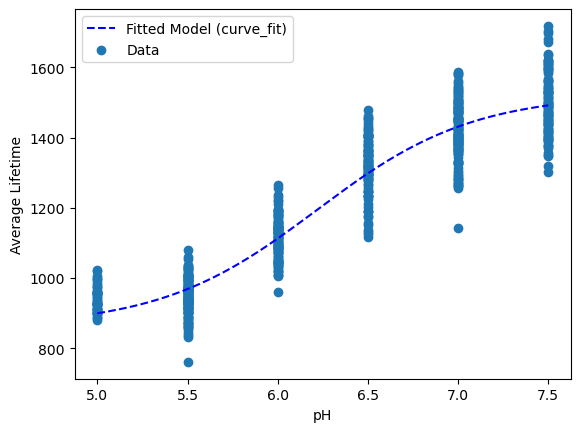

In [6]:
# Define the Henderson-Hasselbalch model function
def hh_model(pH, pKa, tau_HA, tau_Aminus):
    # tau_meas = (tau_HA + tau_Aminus * 10 ** (pH - pKa)) / (1 + 10 ** (pH - pKa))
    ratio = 10 ** (pH - pKa)
    return (tau_HA + tau_Aminus * ratio) / (1 + ratio)


# Build x values for plotting the model
pH_range = np.linspace(df['ph'].min(), df['ph'].max(), 500)


# Use curve_fit to fit the model (least squares)
# Initial guesses for the parameters
initial_params = [6.2, 1500, 950]  # [pKa, tau_HA, tau_Aminus]

# Perform the curve fitting
popt, pcov = curve_fit(hh_model, df['ph'], df['mean_tau'], p0=initial_params)

# Extract the optimal parameters
pKa_cf, tau_HA_cf, tau_Aminus_cf = popt
print(f"Optimal Parameters (curve_fit): pKa={pKa_cf}, tau_HA={tau_HA_cf}, tau_Aminus={tau_Aminus_cf}")

# Calculate standard errors from the covariance matrix
standard_errors_cf = np.sqrt(np.diag(pcov))

# Calculate 95% confidence intervals
z = 1.96  # 95% confidence interval
confidence_intervals_cf = np.array([popt - z * standard_errors_cf, popt + z * standard_errors_cf]).T
print(f"95% Confidence Intervals (curve_fit): pKa={confidence_intervals_cf[0]}, tau_HA={confidence_intervals_cf[1]}, tau_Aminus={confidence_intervals_cf[2]}")

#Additional estimation of the quality of the fit 
residuals = df['mean_tau']- hh_model(df['ph'], *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((df['mean_tau']-np.mean(df['mean_tau']))**2)
r_squared = 1 - (ss_res / ss_tot)

# adjusted R-squared
Adj_r2 = 1 - (1-r_squared) * (len(df['mean_tau'])-1)/(len(df['mean_tau'])-6-1)
print(f"R squared and adjusted R squared: {r_squared}, {Adj_r2}")

# Get predicted lifetimes using the curve_fit parameters
predicted_lifetimes_cf = hh_model(pH_range, pKa_cf, tau_HA_cf, tau_Aminus_cf)

#Plot predicted lifetimes using the HH model parameters 
plt.plot(pH_range, predicted_lifetimes_cf, 'b--', label='Fitted Model (curve_fit)')
# Plot raw data
plt.scatter(df['ph'], df['mean_tau'], label='Data')
plt.xlabel('pH')
plt.ylabel('Average Lifetime')
plt.legend()

<Axes: xlabel='ph'>

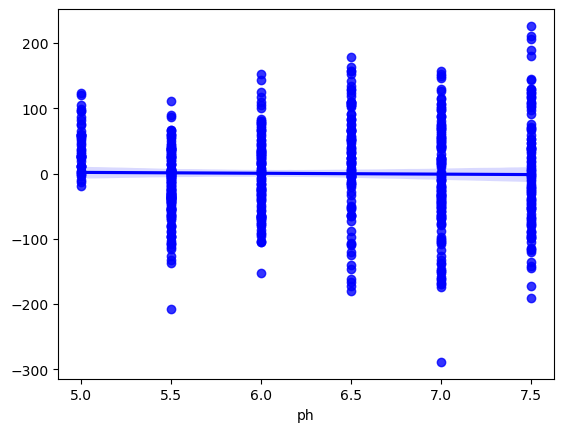

In [5]:

#sns.residplot(x = x_data, y = residuals, lowess=False, color="b")
sns.regplot(x = df['ph'], y = residuals, data = None, scatter = True, color = 'b')

## Saving model parameters

In [7]:
model_data = {
    'parameters': {
        'pKa': pKa_cf,
        'tau_HA': tau_HA_cf,
        'tau_Aminus': tau_Aminus_cf
    },
    'confidence_intervals': {
        'pKa': confidence_intervals_cf[0].tolist(),
        'tau_HA': confidence_intervals_cf[1].tolist(),
        'tau_Aminus': confidence_intervals_cf[2].tolist()
    }
}

# Save to a JSON file
path_to_model_file = 'model_parameters.json'
with open(path_to_model_file, 'w') as json_file:
    json.dump(model_data, json_file, indent=4)


## Below is an example of lifetime data/ pH processing 
This can be used for backfitting, to additionally estimate the curve quality


In [8]:
# Generate an array of pH values
pH_values = np.linspace(5, 7.5, 1000)
# Calculate the corresponding lifetime values
lifetime_values = hh_model(pH_values, pKa_cf, tau_HA_cf, tau_Aminus_cf)

# Create the spline interpolation function
# there are 3 options how it is possible to interpolate the data 
# 1) do not allow extrapolation=False. This will turn all values outside the range to NAN
# 2) include clipping the data, this way it will keep them 7.5 and 5.0 if they fall in the edge (pretty much as raw data looks like)
# 3) dont clip or convent to nan (comment the line with np clip) and have funny values, that you need to filter

spline_interpolator = CubicSpline(lifetime_values, pH_values, extrapolate=True)

,Unnamed: 0,Label,Area,intensity_mean_fluor,mean_chi2,mean_tau,min_fluor,min_chi2,min_tau,STD_fluor,STD_chi2,STD_tau,File Name,ph,Date,selected_analysis,predicted_pH_values
0,5,6,64.0,316.812500,105.828125,1376.703125,258.0,84.0,547.0,30.636924,10.788528,405.804705,3,75,2023-10-12,analyze_single_fitted_channel,6.756633
1,21,22,90.0,305.677778,103.888889,1526.800000,264.0,78.0,792.0,19.310807,10.337036,386.129345,3,75,2023-10-12,analyze_single_fitted_channel,7.500000
2,24,25,104.0,388.144231,109.576923,1435.923077,196.0,86.0,716.0,69.157070,13.119050,360.006856,3,75,2023-10-12,analyze_single_fitted_channel,7.025588
3,27,28,182.0,573.032967,117.230769,1510.093407,402.0,79.0,866.0,77.804411,13.662797,354.495071,3,75,2023-10-12,analyze_single_fitted_channel,7.500000
4,28,29,82.0,410.158537,112.780488,1447.121951,277.0,84.0,813.0,47.372028,12.618245,342.688666,3,75,2023-10-12,analyze_single_fitted_channel,7.092448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,61,62,30.0,470.133333,115.666667,1615.100000,365.0,99.0,1034.0,53.595854,10.386958,260.414714,4,75,2023-09-27,analyze_single_fitted_channel,7.500000
627,62,63,42.0,371.761905,111.309524,1511.690476,286.0,92.0,885.0,44.130655,11.287347,369.690571,4,75,2023-09-27,analyze_single_fitted_channel,7.500000
628,63,64,91.0,368.967033,111.340659,1558.593407,255.0,85.0,756.0,39.240720,12.125914,354.361025,4,75,2023-09-27,analyze_single_fitted_channel,7.500000
629,64,65,30.0,318.666667,107.100000,1703.600000,246.0,87.0,985.0,45.074260,11.858471,297.985637,4,75,2023-09-27,analyze_single_fitted_channel,7.500000


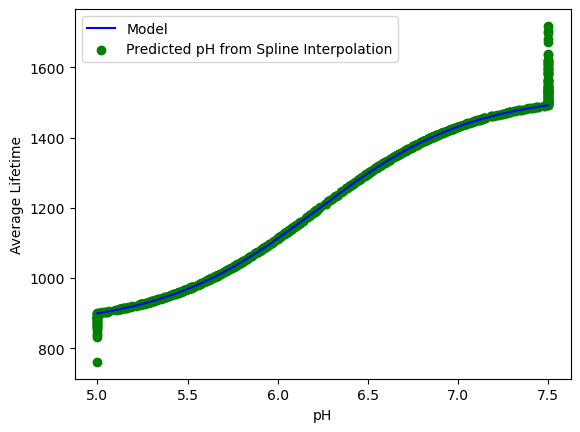

In [10]:
from pathlib import Path
# Load the image data from CSV
image_data_path = Path (r"G:\SP8_FLIM\0_Workflow_OPTIM\pH\Outputs\master_table.csv")
image_data = pd.read_csv(image_data_path)

# Extract mean_tau values as numpy arrays
lifetimes_from_image_data = image_data['mean_tau'].to_numpy()

# Predict pH values for the new lifetimes using the spline interpolation function
predicted_pH_values = spline_interpolator(lifetimes_from_image_data)
predicted_pH_values=np.clip(predicted_pH_values,5.0,7.5)
#print("Predicted pH values (Spline Interpolation):", predicted_pH_values)


# Visualize the original model and the spline interpolation
plt.plot(pH_values, lifetime_values, label='Model', color='blue')
plt.scatter(predicted_pH_values, lifetimes_from_image_data, color='green', label='Predicted pH from Spline Interpolation')
plt.xlabel('pH')
plt.ylabel('Average Lifetime')
plt.legend(loc='upper left')


# Add the pH values as a new column to the DataFrame 
image_data = image_data.assign(predicted_pH_values=predicted_pH_values)
image_data

# Save the DataFrame back to CSV with the new column
#output_path = image_data_path.parent / "master_table_with_ph.csv"
#image_data.to_csv(output_path, index=False)

## Plotting examples 

C:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


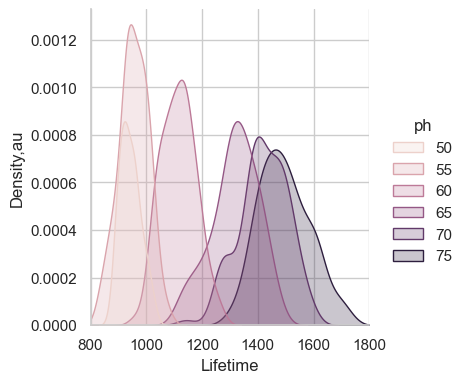

In [7]:
#Optional brif check of what you analized 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def random_choice(data, group_col='ph', n=100):
    sampled_groups = data.groupby(group_col).apply(lambda group: group.sample(min(len(group), n))).reset_index(drop=True)
    return sampled_groups


# Assuming 'data' is your DataFrame
sampled_data = random_choice(image_data, group_col='ph', n=100)


sns.set_theme(style="whitegrid", palette="pastel")
g = sns.displot(
    sampled_data,x="mean_tau", hue="ph",
    kind="kde", fill=True, 
    height=4,  
    
)
g.set_axis_labels("Lifetime", "Density,au")
g.set_titles("{col_name}")
g.set(xlim=(800,1800))
g

#g.savefig('plot.png') 


C:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


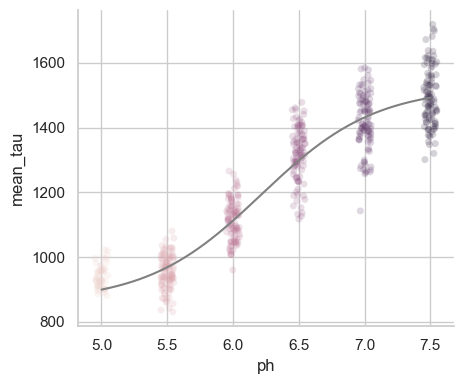

In [9]:
sampled_data['ph'] /= 10
sns.set_theme(style="whitegrid", palette=sns.cubehelix_palette(6))
e=sns.catplot(
    data=sampled_data, x="ph", y="mean_tau", hue="ph",
    native_scale=True, zorder=1,alpha=0.2,aspect=1.2, height=4, 
)

plt.plot(pH_values, lifetime_values, label='Model', color='gray')
#e.savefig('strip-ph-line.png') 
#sns.regplot(
#    data=new1, x="ph", y="tau",
#    scatter=False, truncate=False, order=2, color=".2")

C:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\m

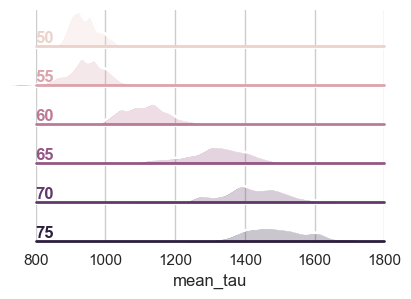

In [10]:
# Initialize the FacetGrid object
sns.set_theme(style="whitegrid", palette=sns.cubehelix_palette(6))
g = sns.FacetGrid(image_data, row="ph", hue="ph", aspect=9, height=.5)

# Draw the densities in a few steps
g.map(sns.kdeplot, "mean_tau",
      bw_adjust=.6,
      fill=True, clip_on=False)

g.map(sns.kdeplot, "mean_tau", color="w", lw=2, bw_adjust=.6,clip_on=False)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0.1)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "mean_tau")

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xlim=(800,1800))
g.despine(bottom=True, left=True)


C:\Users\med\AppData\Local\Temp\ipykernel_11788\4166357710.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([f'{tick:.1f}' for tick in ph_ticks])


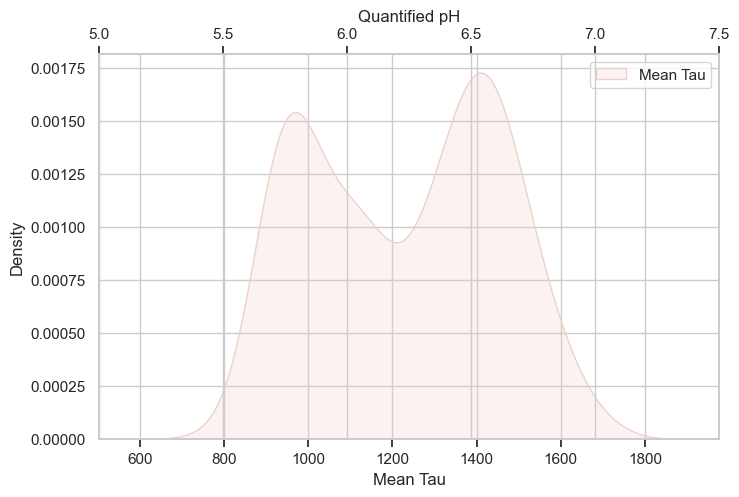

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'data' is your DataFrame
sampled_data = random_choice(image_data, group_col='ph', n=100)


# Set up the figure and the main subplot
fig, ax = plt.subplots(figsize=(8, 5))

# Create the KDE plot for mean_tau
sns.kdeplot(data=sampled_data, x="mean_tau", fill=True, ax=ax, label='Mean Tau')

# Set labels and title for the main plot
ax.set_xlabel("Mean Tau")
ax.set_ylabel("Density")
#ax.set_title("KDE Plot with Dual X-Axes for pH and Mean Tau")

# Create a second x-axis for pH values
ax2 = ax.twiny()

# Set the limits for pH axis (5.0 to 7.5)
pH_min = 5.0
pH_max = 7.5
ax2.set_xlim(pH_min, pH_max)

# Round and set specific ticks for the pH axis
#ph_ticks = [5.0, 5.5, 6.0, 6.5, 7.0, 7.5]
#ax2.set_xticks(ph_ticks)

# Set labels for the pH axis
ax2.set_xticklabels([f'{tick:.1f}' for tick in ph_ticks])

# Set label for the pH axis
ax2.set_xlabel("Quantified pH")

# Hide the y-axis for the second x-axis
ax2.get_yaxis().set_visible(False)

# Add legend
ax.legend()

plt.show()


In [31]:
sampled_data['predicted_pH_values']

0      5.326470
1      5.620018
2      5.248095
3      5.044415
4      5.451575
         ...   
543    7.281887
544    7.500000
545    7.500000
546    7.500000
547    7.500000
Name: predicted_pH_values, Length: 548, dtype: float64

KeyError: 'predicted_ph'

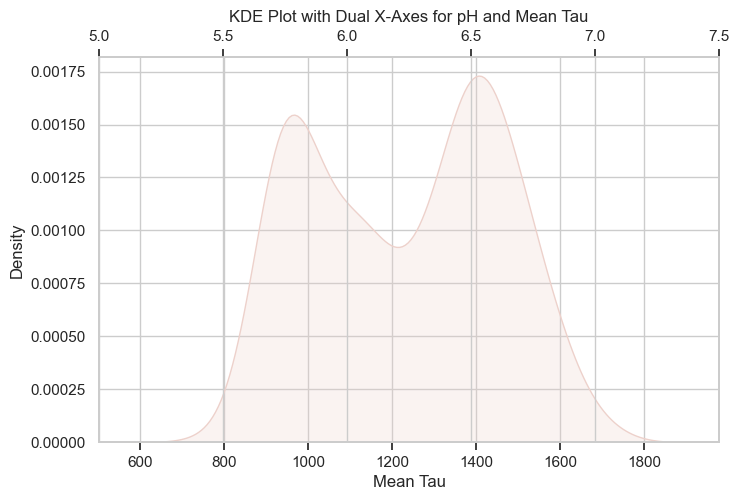

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Assuming 'data' is your DataFrame
sampled_data = random_choice(image_data, group_col='ph', n=100)


# Set up the figure and the main subplot
fig, ax = plt.subplots(figsize=(8, 5))

# Create the KDE plot for mean_tau
sns.kdeplot(data=sampled_data, x="mean_tau", fill=True, ax=ax, label='Mean Tau')

# Set labels and title for the main plot
ax.set_xlabel("Mean Tau")
ax.set_ylabel("Density")
ax.set_title("KDE Plot with Dual X-Axes for pH and Mean Tau")

# Create a second x-axis for pH values
ax2 = ax.twiny()

# Set the limits for pH axis (5.0 to 7.5)
pH_min = 5.0
pH_max = 7.5
ax2.set_xlim(pH_min, pH_max)

# Set ticks and labels for the pH axis based on predicted_ph
ph_ticks = sampled_data['predicted_ph'].unique()
ax2.set_xticks(ph_ticks)

# Set labels for the pH axis
ax2.set_xticklabels([f'{tick:.1f}' for tick in ph_ticks])

# Set label for the pH axis
ax2.set_xlabel("Predicted pH")

# Hide the y-axis for the second x-axis
ax2.get_yaxis().set_visible(False)

# Add legend
ax.legend()

plt.show()
